In [674]:
import numpy as np
import pandas as pd
from casadi import *
import yaml
import seaborn as sns
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

from bofire.data_models.strategies.api import RandomStrategy
import bofire.strategies.api as strategies
from bofire.data_models.api import Domain, Outputs, Inputs
from bofire.data_models.features.api import ContinuousInput
from bofire.strategies.doe.design import find_local_max_ipopt
PATH_TO_CFG = "../models/EtOxModel/EtOxModel.yaml"


with open(PATH_TO_CFG, "r") as f:
    p = yaml.safe_load(f)["equation_parameters"]


In [1194]:
# Berty-Modell to sample measured steady state reaction speeds
input_state_names = ["T_in", "p_in", "yE_in", "yO2_in", "yCO2_in", "F"]
x_ub = np.array([700, 25e5, 0.065, 0.195, 0.01])
x_lb = np.array([500, 15e5, 0.03, 0.18, 0.001])
def generate_inputs(n: int = 10, random=False, seed=None):
    input_vars = Inputs(features=[
        ContinuousInput(key="T_in", unit="K", bounds=(x_lb[0], x_ub[0])),
        ContinuousInput(key="p_in", unit="Pa", bounds=(x_lb[1], x_ub[1])),
        ContinuousInput(key="yE_in", unit="1", bounds=(x_lb[2], x_ub[2])),
        ContinuousInput(key="yO2_in", unit="1", bounds=(x_lb[3], x_ub[3])),
        ContinuousInput(key="yCO2_in", unit="1", bounds=(x_lb[4], x_ub[4])),
        ContinuousInput(key="F", unit="m3/s", bounds=(5e-3 / 3600, 300e-3 / 3600)),
    ])
    domain = Domain(inputs=input_vars)
    if random:
        datamodel = RandomStrategy(domain=domain, seed=seed)
        sampler = strategies.map(data_model=datamodel)
        input_states = sampler.ask(n)
    else:
        input_states = find_local_max_ipopt(domain, "linear", n_experiments=n, ipopt_options={"disp":0}).reset_index(drop=True)
    input_states = input_states[input_state_names]
    return input_states.to_numpy()

inputs = generate_inputs(n=1, random=True)

state_names = ["T", "p", "yE", "yO2", "yCO2"]
K1, K2 = float(p["K1"]), float(p["K2"])
nx = 5
nparam = 4
m_kat = 0.063 #  kg Kat
x_in = SX.sym("x_in", 6)  # input states, mit Dimensionen
x_var = SX.sym("x", nx)  # states
th_ub = np.array([log(1e7), 1e5, log(2e7), 1e5])
th_lb = np.array([log(1e6), 5e4, log(5e5), 5e4])
th_var = SX.sym("th", nparam)
th_real = np.array([p["k1"], p["EA1"], p["k2"], p["EA2"]], dtype=float)
lnth_real = np.array([log(th_real[0]), th_real[1], log(th_real[2]), th_real[3]])
r1 = lambda x, th: th[0] * exp(-th[1] / (p["R_g"] * x[0])) * (x[2] * x[1]) ** 0.6 * (x[3] * x[1]) ** 0.5 / (1 + K1 * exp(p["Tads1"] / x[0]) * x[1] * x[4]) # mol / (g_kat h)
r2 = lambda x, th: th[2] * exp(-th[3] / (p["R_g"] * x[0])) * (x[2] * x[1]) ** 0.5 * (x[3] * x[1]) ** 0.5 / (1 + K2 * exp(p["Tads2"] / x[0]) * x[1] * x[4])
lnr1 = lambda x, th: th[0] - th[1] / (p["R_g"] * x[0]) + log((x[2] * x[1]) ** 0.6 * (x[3] * x[1]) ** 0.5 / (1 + K1 * exp(p["Tads1"] / x[0]) * x[1] * x[4])) # ln (mol / (g_kat h))
lnr2 = lambda x, th: th[2] - th[3] / (p["R_g"] * x[0]) + log((x[2] * x[1]) ** 0.5 * (x[3] * x[1]) ** 0.5 / (1 + K2 * exp(p["Tads2"] / x[0]) * x[1] * x[4]))
nu_E = (-1, -1)
nu_O2 = (-0.5, -3)
nu_CO2 = (0, 2)

A = x_in[5] * x_var[1] / (p["R_g"] * x_var[0] * m_kat)
rhs = vertcat(*[
    A * (x_in[2] - x_var[2]) + nu_E[0] * r1(x_var, th_real) + nu_E[1] * r2(x_var, th_real),
    A * (x_in[3] - x_var[3]) + nu_O2[0] * r1(x_var, th_real) + nu_O2[1] * r2(x_var, th_real),
    A * (x_in[4] - x_var[4]) + nu_CO2[1] * r2(x_var, th_real),
    x_in[0] - x_var[0],
    x_in[1] - x_var[1],
])
rhs_fun = Function("Berty_Rhs", [x_in, x_var], [rhs])

In [1173]:
opts = {  # IPOPT print ops
            "ipopt.tol": 1e-6,
            "ipopt.print_level": 1,  # Unterdrückt die IPOPT-Ausgabe
            "print_time": 0,  # Unterdrückt die Ausführungszeit
            "ipopt.sb": "yes",  # Unterdrückt die IPOPT-Fehlerausgabe
        }

def simulate(X_in: np.array):
    '''Simulates the berty reactor to calculate steady state reaction rates.'''
    sol_x = np.zeros((X_in.shape[0], nx))
    for i, x_in_i in enumerate(X_in):
        nlp = {"x": x_var, "f": 0, "g": rhs_fun(x_in_i, x_var)}
        solver = nlpsol("solver", "ipopt", nlp, opts)
        solution = solver(lbx=x_lb, ubx=x_ub, lbg=0, ubg=0, x0=x_in_i[:-1])
        sol_x[i, :] = solution["x"].full().flatten()
    return sol_x
    
def calculate_rates(X, meas_noise: float = 0):
    '''Calculates the rates with and without measurement noise.'''
    noise = np.random.normal(loc=0, scale=meas_noise*X, size=X.shape)
    rates = np.concatenate([r1(X.T, th_real), r2(X.T, th_real)], axis=1)
    X_noisy = X + noise
    noisy_rates = np.concatenate([r1(X_noisy.T, th_real), r2(X_noisy.T, th_real)], axis=1)
    return np.concatenate([rates, noisy_rates], axis=1)

def test_parety_plots(N_points: float = 100): 
    X_in = generate_inputs(N_points, random=True)
    rates = np.zeros((N_points, 4))
    X = simulate(X_in)
    rates = calculate_rates(X, meas_noise=0.01)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
    ax[0].scatter(rates[:, 0], rates[:, 2], marker="+")
    ax[1].scatter(rates[:, 1], rates[:, 3], marker="+")
    ax[0].set_xlabel(r"$r_1$"); ax[0].set_ylabel(r"$\hat{r}_1$")
    ax[1].set_xlabel(r"$r_2$"); ax[1].set_ylabel(r"$\hat{r}_2$")
    plt.show()

X_in = generate_inputs(10, random=True, seed=42)
X = simulate(X_in)
calculate_rates(X, meas_noise=0.01)

array([[1.05163482e-02, 2.80610077e-03, 1.30749872e-02, 3.54315323e-03],
       [1.78119282e-02, 5.07940180e-03, 1.47640507e-02, 4.14476360e-03],
       [9.60916171e-03, 2.64705702e-03, 1.09264868e-02, 3.04599230e-03],
       [6.32695467e-03, 1.66304314e-03, 6.01465114e-03, 1.57347051e-03],
       [1.57998420e-04, 2.69804557e-05, 1.79134458e-04, 3.09003765e-05],
       [1.63832436e-03, 3.26981509e-04, 1.74902065e-03, 3.51186765e-04],
       [1.73186112e-03, 3.98372513e-04, 1.89478486e-03, 4.39053654e-04],
       [8.08097557e-04, 1.54213203e-04, 6.55608711e-04, 1.23253398e-04],
       [2.84750631e-02, 8.17688039e-03, 3.20520785e-02, 9.28787848e-03],
       [9.92437493e-03, 2.68808679e-03, 7.69084271e-03, 2.03544763e-03]])

In [1174]:
# Fit the parameters to the rates and determine the covariance matrix
loss = lambda r_true, x, th: sum1((lnr1(x, th) - log(r_true[0])) ** 2 + (lnr2(x, th) - log(r_true[1])) ** 2)

def fit(X, r_true):
    '''Fits the parameters theta to the reaction rates'''
    loss_expr = loss(r_true.T, X.T, th_var)
    nlp = {"x": th_var, "f": loss_expr}
    th_init = np.random.uniform(low=th_lb, high=th_ub)
    solver = nlpsol("solver", "ipopt", nlp, opts)
    solution = solver(ubx=th_ub, lbx=th_lb, x0=th_init)
    return solution["x"].full().flatten(), np.squeeze(solution["f"].full())

X_in = generate_inputs(n=10, random=True)
X = simulate(X_in)
Y = calculate_rates(X, meas_noise=0.01)
fit(X, Y[:, 2:])

(array([1.47838052e+01, 7.10697054e+04, 1.54249686e+01, 8.60451177e+04]),
 array(0.61571542))

In [1215]:
N_exp = 500
npoints = 128
noise = 0.03
results = np.zeros((N_exp, 4))

X_in = generate_inputs(n=npoints, random=True)
X = simulate(X_in)
for i in tqdm(range(N_exp)):
    Y = calculate_rates(X, meas_noise=noise)
    fit_res = fit(X, Y[:, 2:])
    results[i, :] = fit_res[0]

results

100%|██████████| 500/500 [00:07<00:00, 65.13it/s]


array([[1.43999596e+01, 6.90058974e+04, 1.49483919e+01, 8.35135269e+04],
       [1.57380568e+01, 7.58474653e+04, 1.63987312e+01, 9.09315044e+04],
       [1.55552150e+01, 7.47997366e+04, 1.62061790e+01, 8.98209844e+04],
       ...,
       [1.56702576e+01, 7.50027143e+04, 1.63321990e+01, 9.00404393e+04],
       [1.55175947e+01, 7.40968503e+04, 1.61601491e+01, 8.90309779e+04],
       [1.52432923e+01, 7.28064126e+04, 1.58642899e+01, 8.76404001e+04]])

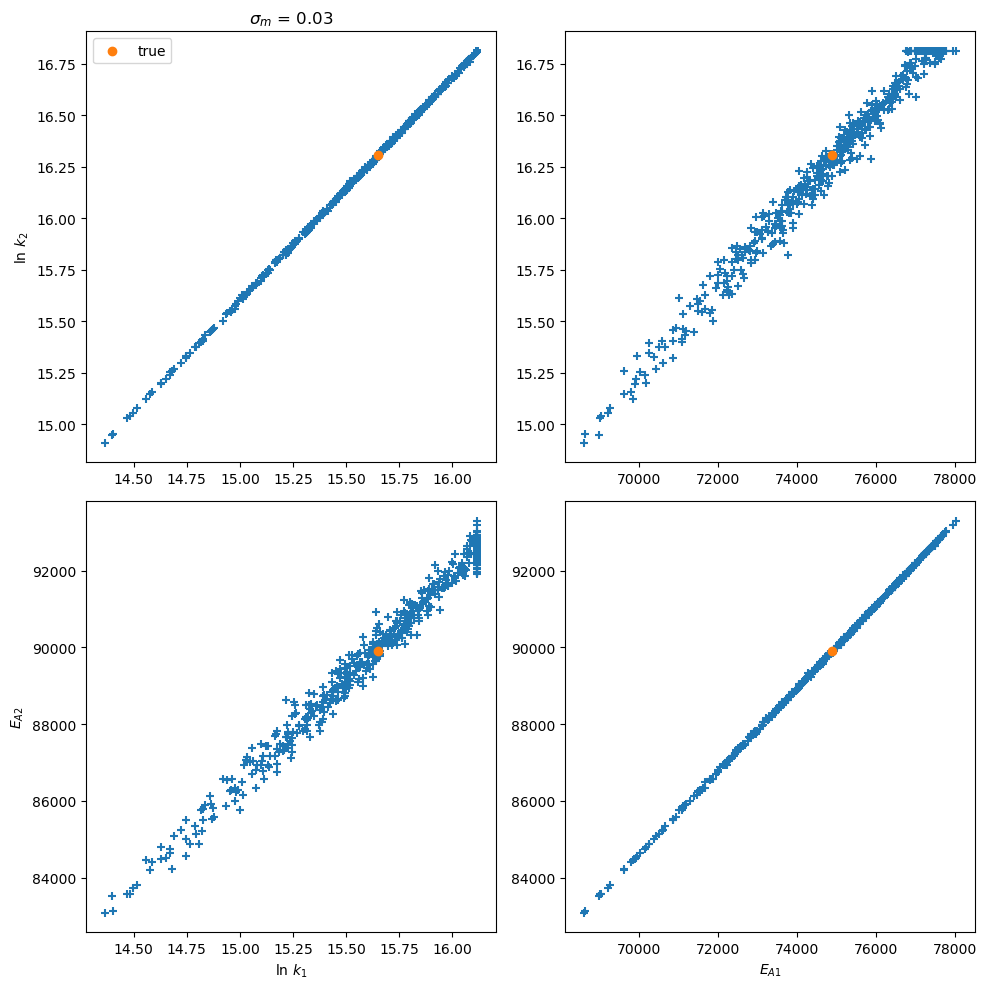

In [1406]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].scatter(results[:, 0], results[:, 2], marker="+")
ax[0,0].scatter(np.log(th_real[0]), np.log(th_real[2]), label="true")

ax[1,0].scatter(results[:, 0], results[:, 3], marker="+")
ax[1,0].scatter(np.log(th_real[0]), th_real[3], label="true")

ax[0,1].scatter(results[:, 1], results[:, 2], marker="+")
ax[0,1].scatter(th_real[1], np.log(th_real[2]), label="true")

ax[1,1].scatter(results[:, 1], results[:, 3], marker="+")
ax[1,1].scatter(th_real[1], th_real[3], label="true")

ax[1,0].set_xlabel(r"ln $k_1$"); ax[0,0].set_ylabel(r"ln $k_2$"); 
ax[1,1].set_xlabel(r"$E_{A1}$"); ax[1,0].set_ylabel(r"$E_{A2}$"); 
ax[0,0].set_title(fr"$\sigma_m$ = {noise}")
ax[0,0].legend()
plt.tight_layout()
plt.show()

Es ist zu erkennen, dass die Aktivierungsenergien und auch die Stoßfaktoren positiv miteinander korrelieren. Das liegt daran, dass in einem Berty-Reaktor, bei dem der stationäre Zustand abgewartet wird, nicht die Geschwindigkeit der einzelnen Reaktionen separat betrachtbar ist. Wenn Reaktion 1 langsamer wird, wird auch Reaktion 2 langsamer. Daher werden auch Aktivierungsenergien und Stoßfaktoren gleichzeitig in dieselbe Richtung geschätzt.

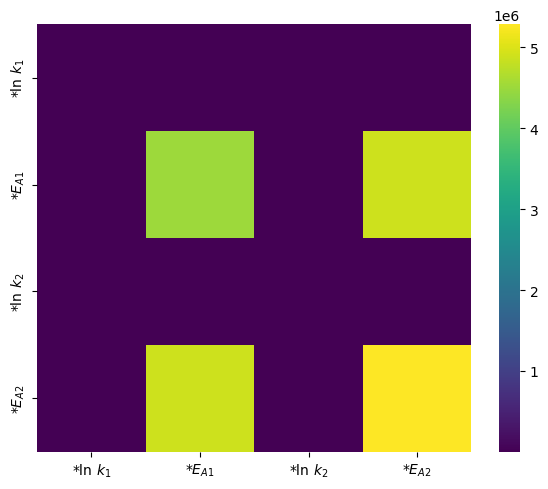

array([[1.75771835e-01, 8.84054955e+02, 1.90226410e-01, 9.56652289e+02],
       [8.84054955e+02, 4.51587249e+06, 9.56722528e+02, 4.88651035e+06],
       [1.90226410e-01, 9.56722528e+02, 2.05897698e-01, 1.03542590e+03],
       [9.56652289e+02, 4.88651035e+06, 1.03542590e+03, 5.28826120e+06]])

array([1.56214535e+01, 7.48563390e+04, 1.62725568e+01, 8.98538394e+04])

In [1239]:
C = np.cov(results.T)
mean = results.mean(axis=0)
plt.figure(figsize=(6, 5))
labels = [r"*ln $k_1$", r"*$E_{A1}$", r"*ln $k_2$", r"*$E_{A2}$"]
sns.heatmap(C, annot=False, fmt=".2f", cmap="viridis", square=False,
            xticklabels=labels,
            yticklabels=labels,)
            #vmin=0.9, vmax=1.05)
plt.tight_layout()
plt.show()
display(C, mean)

In [ ]:
# sample the parameters

np.random.multivariate_normal(mean, C**0.5)

array([1.63387359e+01, 7.49137273e+04, 1.70159106e+01, 8.99133241e+04])